In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 1D Fourier differentiation

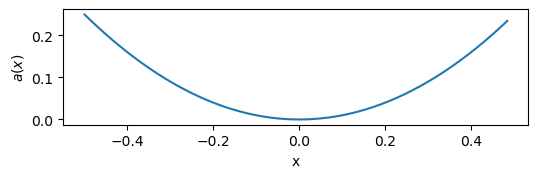

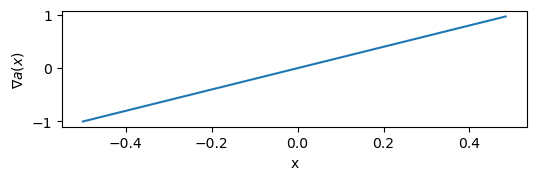

In [161]:
def plot(x, a, xlabel, ylabel, label=None):
    x = x.detach().cpu().numpy()
    a = a.detach().cpu().numpy()
    fig, ax = plt.subplots(figsize=(6,1.5))
    ax.plot(x, a, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if label is not None:
        ax.legend(frameon=False)

# spatial domain function

def a(x):
    return x**2
    x = 8 * np.pi * x
    return torch.exp((-x**2) / 16)

# set of discrete spatial samples
N = 64
L = 1
dx = L/N
x = torch.arange(-L/2, L/2, dx)
x.requires_grad = True

# function evaluated at spatial samples
a_x = a(x)

# exact gradient at spatial samples
grad_a_x = torch.autograd.grad(a_x, x, grad_outputs=torch.ones_like(a_x))[0]

plot(x, a_x, 'x', '$a(x)$')
plot(x, grad_a_x, 'x', '$\\nabla a(x)$')

In [162]:
# complex sinusoid basis functions

def phi(x, s, conj=False, dx=0, ds=0):
    x_dot_s = torch.einsum('n,k->nk', x, s)
    value = torch.exp(2j * np.pi * x_dot_s)
    value = value * (2j * np.pi * s[None,:])**dx
    value = value * (2j * np.pi * x[:,None])**ds
    return torch.conj_physical(value) if conj else value

# set of discrete spatial frequencies
K = N
s = torch.arange(K)

#phi_xs = phi(x, s, conj=True)
#print(phi_xs.shape)
#plot(x, phi_xs.real, 'x', '$\phi(x)$')
#plot(x, phi_xs.imag, 'x', '$\phi(x)$')

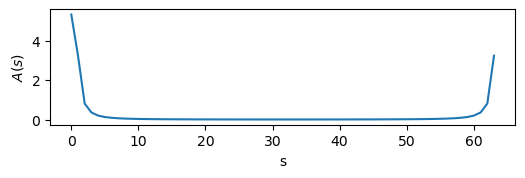

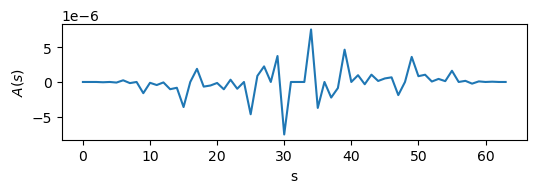

In [163]:
# discrete Fourier transform

def DFT(x, a_x):
    N = len(x)
    def A(s, ds=0):
        return 1 / N * (a_x[:,None] * phi(x, s, conj=True, ds=ds)).sum(0)
    return A

#A = DFT(x, a_x)
#A_s = A(s)
A_s = torch.fft.fft(a_x, norm='backward')

plot(s, torch.abs(A_s), 's', '$A(s)$')
plot(s, torch.angle(A_s), 's', '$A(s)$')

torch.Size([64])
torch.Size([64])


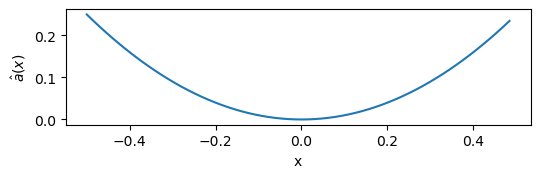

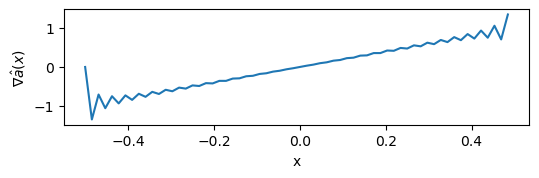

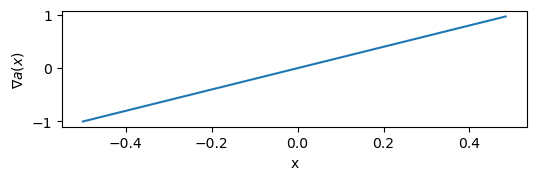

In [164]:
# inverse discrete Fourier transform

def IDFT(s, A_s, real=False):
    K = len(s)
    def a(x, dx=0):
        a_x = (A_s[None,:] * phi(x, s, dx=dx)).sum(1)
        return 2 * a_x.real if real else a_x
    return a

#ahat = IDFT(s, A_s, real=True)
#ahat_x = ahat(x, dx=1)
ahat_x = torch.fft.ifft(A_s, norm='backward')

print(A_s.shape)
print(s.shape)

ss = torch.fft.fftshift(s)
grad_ahat_x = torch.fft.ifft((2j*np.pi*ss) * A_s, norm='backward')

plot(x, ahat_x, 'x', '$\hat{a}(x)$')
plot(x, grad_ahat_x, 'x', '$\\nabla \hat{a}(x)$')
plot(x, grad_a_x, 'x', '$\\nabla a(x)$')

# 2D Fourier differentiation

x torch.Size([256, 256, 2])
a_x torch.Size([256, 256])
grad_a_x torch.Size([256, 256, 2])


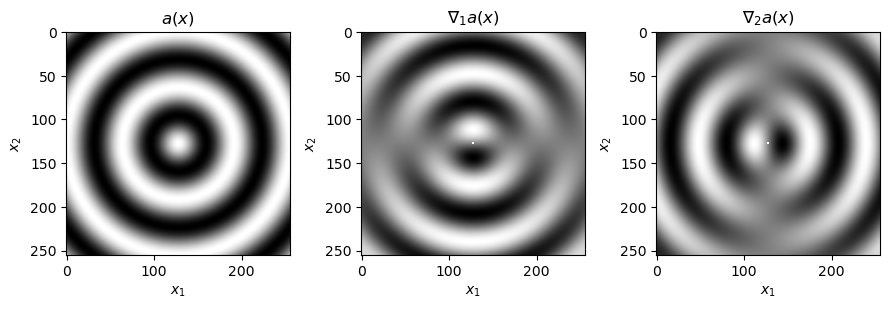

In [231]:
def imshow(ax, a, xlabel, ylabel, title):
    a = a.detach().cpu().numpy()
    ax.imshow(a, cmap='gray')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

# spatial domain function

def a(x):
    freq = 4
    dist = (x**2).sum(-1)**0.5
    return torch.cos(2*np.pi*freq*dist)

# set of discrete spatial samples
N = 256
L = 1
dx = L/N
x = torch.arange(-L/2, L/2, dx)
x = torch.stack(torch.meshgrid(x, x), -1)
x.requires_grad = True
print('x', x.shape)

# function evaluated at spatial samples
a_x = a(x)
print('a_x', a_x.shape)

# exact gradient at spatial samples
grad_a_x = torch.autograd.grad(a_x, x, grad_outputs=torch.ones_like(a_x))[0]
print('grad_a_x', grad_a_x.shape)

fig, ax = plt.subplots(1, 3, figsize=(9,3))
imshow(ax[0], a_x, '$x_1$', '$x_2$', '$a(x)$')
imshow(ax[1], grad_a_x[...,0], '$x_1$', '$x_2$', '$\\nabla_1 a(x)$')
imshow(ax[2], grad_a_x[...,1], '$x_1$', '$x_2$', '$\\nabla_2 a(x)$')
fig.tight_layout()

A_s torch.Size([256, 256])


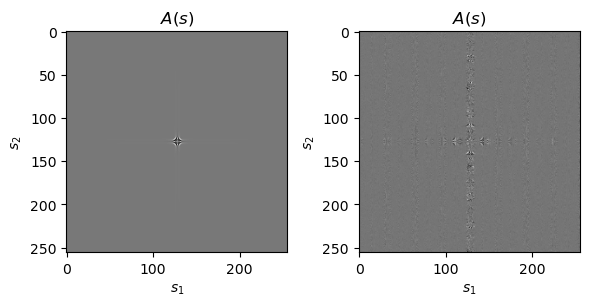

In [232]:
A_s = torch.fft.fftn(a_x, norm='backward')
print('A_s', A_s.shape)

fig, ax = plt.subplots(1, 2, figsize=(6,3))
imshow(ax[0], torch.fft.fftshift(A_s.real), '$s_1$', '$s_2$', '$A(s)$')
imshow(ax[1], torch.fft.fftshift(A_s.imag), '$s_1$', '$s_2$', '$A(s)$')
fig.tight_layout()

ahat_x torch.Size([256, 256])
s torch.Size([256, 256, 2])
grad_ahat_x torch.Size([256, 256, 2])


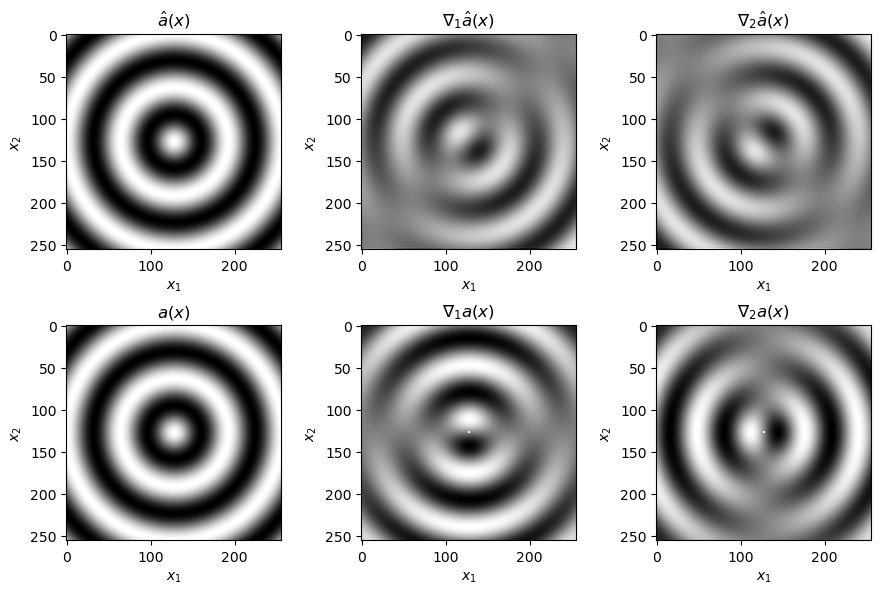

In [240]:
ahat_x = torch.fft.ifftn(A_s, norm='backward')
ahat_x = ahat_x.real
print('ahat_x', ahat_x.shape)

K = N
s = torch.arange(K)
s = torch.stack(torch.meshgrid(s, s), -1)
print('s', s.shape)

ss = torch.fft.fftshift(s)
A_ss = torch.fft.fftshift(A_s)
grad_ahat_x = torch.fft.ifftn((2j*np.pi*ss) * A_s[...,None], norm='backward')
grad_ahat_x = grad_ahat_x.real
print('grad_ahat_x', grad_ahat_x.shape)

fig, ax = plt.subplots(2, 3, figsize=(9,6))
imshow(ax[0,0], ahat_x, '$x_1$', '$x_2$', '$\hat{a}(x)$')
imshow(ax[0,1], grad_ahat_x[...,0], '$x_1$', '$x_2$', '$\\nabla_1 \hat{a}(x)$')
imshow(ax[0,2], grad_ahat_x[...,1], '$x_1$', '$x_2$', '$\\nabla_2 \hat{a}(x)$')
imshow(ax[1,0], a_x, '$x_1$', '$x_2$', '$a(x)$')
imshow(ax[1,1], grad_a_x[...,0], '$x_1$', '$x_2$', '$\\nabla_1 a(x)$')
imshow(ax[1,2], grad_a_x[...,1], '$x_1$', '$x_2$', '$\\nabla_2 a(x)$')
fig.tight_layout()

In [ ]:
class FFT(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, f_x):
        F_s = torch.fft.fftn(input)
        ctx.save_for_backward()
        return F_s
    
    @staticmethod
    def backward(ctx, grad_output):
        pass